## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'


# Surface Area
# fs60_aparc_lh_SA_file = 'aparc_lh_SA_table.test1'
# fs60_aparc_rh_SA_file = 'aparc_rh_SA_table.test1'
# fs60_aparc2009_lh_SA_file = 'lh.aparc.a2009.SA.table.test1'
# fs60_aparc2009_rh_SA_file = 'rh.aparc.a2009.SA.table.test1'


### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [5]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Compare ML performance 

In [7]:
covar_continuous_cols = [] #'AGE_AT_SCAN'
covar_cat_cols = ['SEX','SITE_ID'] #'SEX','SITE_ID','DX_GROUP'

model_type = 'classification'

if model_type.lower() == 'regression':
    outcome_col = 'AGE_AT_SCAN'
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
else: 
    outcome_col = 'DX_GROUP'
    #model = svm.SVC(kernel='linear')
    model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

ml_perf_dict = {}

start_time_ML = time.time()
for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('Atlas {}'.format(atlas))
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    roi_cols = master_df.filter(regex='^L|R_', axis=1).columns
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    ml_perf = getMLModelPerf(master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)
    ml_perf_dict[atlas] = ml_perf
    
    print('time to process atlas {:4.3f}s \n'.format(time.time()-start_time_atlas))
    

print('time to process ML {:4.3}s'.format(time.time()-start_time_ML))


Atlas aparc
Running ML classifer on 1 pipelines
Using 2 col for 21 cat covar
Data shapes X (1047, 89), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
Pipeline aparc,  Perf mean:0.534, sd:0.057
time to process atlas 5.479s 

Atlas Destrieux
Running ML classifer on 1 pipelines
Using 2 col for 21 cat covar
Data shapes X (1047, 169), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
Pipeline Destrieux,  Perf mean:0.542, sd:0.058
time to process atlas 7.115s 

Atlas Glasser
Running ML classifer on 1 pipelines
Using 2 col for 21 cat covar
Data shapes X (1047, 381), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
Pipeline Glasser,  Perf mean:0.537, sd:0.058
time to process atlas 9.720s 

time to process ML 22.3s



### Compare statsmodels performance 

In [11]:
covar_continuous_cols = ['AGE_AT_SCAN']
covar_cat_cols = ['SEX','SITE_ID']
outcome_col = 'DX_GROUP' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #ols #logit
stat_perf_dict = {}
save_sm_perf = True

for atlas in data_dict.keys():
    mr_data_df = data_dict[atlas]
    roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
    master_df = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ input_cols],on=subject_ID_col)
    master_df['pipeline'] = np.tile(atlas,len(master_df))
    
    #Save standarized df to csv for outlier detection
    #master_df.to_csv(fs60_dir + '{}_standarized.csv'.format(atlas))
    
    sm_perf = getStatModelPerf(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    print('Top 10 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(10)))
    print('')
    
if save_sm_perf:
    save_path = '{}atlas_sm_perf_{}.pkl'.format(results_dir,outcome_col)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    with open(save_path, 'wb') as handle:
        pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Running 68 mass-univariate logit statsmodels on 1 pipelines
Example statsmodel run:
 DX_GROUP ~ R_insula + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (68, 4)
Top 10 significant regions:
                       roi pipeline     t_val     p_val
45              R_lingual    aparc -3.640070  0.000273
19        L_pericalcarine    aparc -3.586604  0.000335
11              L_lingual    aparc -3.527087  0.000420
3                L_cuneus    aparc -3.052464  0.002270
12  L_medialorbitofrontal    aparc -2.945105  0.003228
9      L_lateraloccipital    aparc -2.903514  0.003690
43     R_lateraloccipital    aparc -2.838550  0.004532
4            L_entorhinal    aparc  2.796709  0.005163
49          R_paracentral    aparc  2.605210  0.009182
56           R_precentral    aparc  2.490179  0.012768

Running 360 mass-univariate logit statsmodels on 1 pipelines
Example statsmodel run:
 DX_GROUP ~ R_p24_ROI + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df

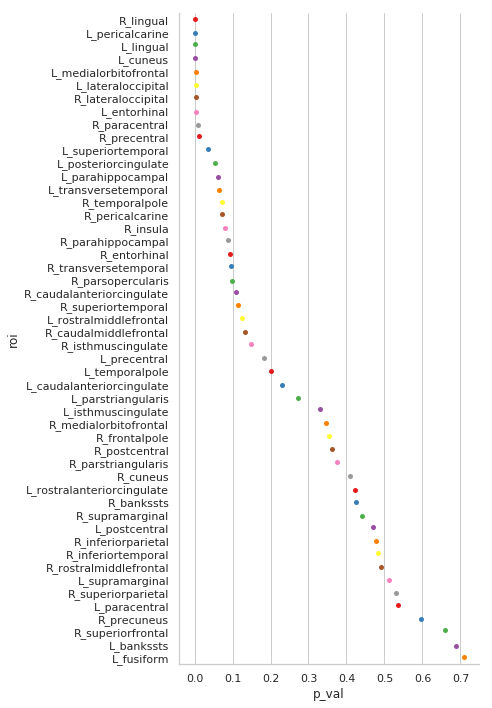

In [12]:
# Plots
aparc = 'aparc' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");